# SPEECH TO TEXT TRANSLATION

Proyek speech-to-text translation ini bertujuan untuk mengidentifikasi bahasa audio (Inggris atau Indonesia), mengonversinya menjadi teks, dan menerjemahkannya ke bahasa lain. Pertama, dataset audio diolah menggunakan pustaka seperti pydub atau librosa untuk memuat dan membersihkan file audio, termasuk pengurangan kebisingan dengan noisereduce. Selanjutnya, model speech-to-text seperti OpenAI Whisper digunakan untuk mentranskripsi audio menjadi teks, yang kemudian dideteksi bahasanya menggunakan pustaka langdetect. Berdasarkan hasil deteksi bahasa, teks diterjemahkan menggunakan Google Translate API (dengan pustaka googletrans) ke bahasa target. Hasil transkripsi dan terjemahan dapat disimpan dan divisualisasikan menggunakan matplotlib untuk analisis lebih lanjut.

In [1]:
!pip install pydub matplotlib scipy noisereduce numpy librosa openai-whisper langdetect googletrans==4.0.0-rc1 ffmpeg-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.5/800.5 kB 15.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 53.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.5/209.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 60.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 67.3 MB/s et

# BACA DATA DAN CONVERT KE WAV

Langkah pertama adalah membaca data audio dan mengonversinya ke format WAV agar kompatibel dengan model speech-to-text. Menggunakan pustaka pydub, file audio seperti dataset.mp3 dimuat, dan formatnya dapat dikonversi ke WAV jika diperlukan. Selain itu, pustaka IPython.display.Audio digunakan untuk memutar file audio secara langsung dalam lingkungan Jupyter Notebook, memungkinkan pengguna untuk memverifikasi isi audio sebelum melanjutkan pemrosesan lebih lanjut.

In [19]:
from pydub import AudioSegment
from IPython.display import Audio
import os

mp3_file = "indo_dataset.mp3"
print(f"Memutar file: {mp3_file}")
Audio(mp3_file)

Memutar file: indo_dataset.mp3


In [20]:
# Konversi MP3 ke WAV
def convert_to_wav(mp3_path):
    wav_path = os.path.splitext(mp3_path)[0] + ".wav"
    audio = AudioSegment.from_mp3(mp3_path)
    audio.export(wav_path, format="wav")
    return wav_path

wav_file = convert_to_wav(mp3_file)
print(f"File WAV telah disimpan sebagai: {wav_file}")

File WAV telah disimpan sebagai: indo_dataset.wav


# MENAMPILKAN SINYAL ASLI DARI DATASET

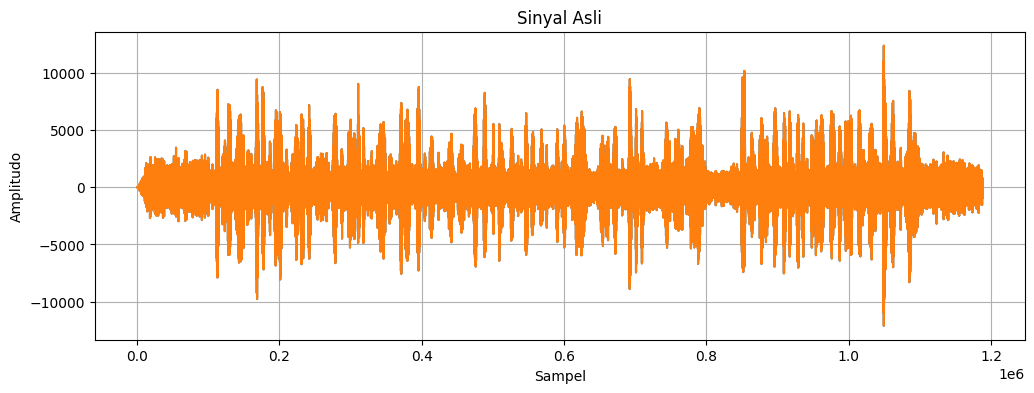

In [21]:
import matplotlib.pyplot as plt
from scipy.io import wavfile

def plot_signal(wav_path):
    sample_rate, signal = wavfile.read(wav_path)
    plt.figure(figsize=(12, 4))
    plt.plot(signal)
    plt.title("Sinyal Asli")
    plt.xlabel("Sampel")
    plt.ylabel("Amplitudo")
    plt.grid()
    plt.show()
    return sample_rate, signal

# Menampilkan sinyal asli
sample_rate, original_signal = plot_signal(wav_file)

# REMOVE NOISE

Langkah kedua adalah menghapus kebisingan dari file audio untuk meningkatkan kualitas transkripsi. File audio WAV dibaca menggunakan scipy.io.wavfile, dan jika data audio memiliki lebih dari satu saluran, dikonversi menjadi mono dengan rata-rata nilai saluran. Sebagai sampel kebisingan, 1 detik pertama data audio digunakan untuk melatih pustaka noisereduce, yang kemudian mengurangi kebisingan pada seluruh file. Hasil audio yang telah dibersihkan disimpan sebagai file WAV menggunakan wavfile.write dan dikonversi ke format MP3 dengan pydub. File output yang bersih siap digunakan untuk langkah selanjutnya, seperti transkripsi suara.

In [22]:
import numpy as np
from scipy.io import wavfile
from pydub import AudioSegment
import noisereduce as nr

# Fungsi untuk menghapus noise
def remove_noise(wav_file, output_wav, output_mp3):
    rate, data = wavfile.read(wav_file)

    if len(data.shape) > 1:
        data = np.mean(data, axis=1).astype(data.dtype)

    noise_sample = data[:rate]  # 1 detik pertama

    # Reduksi noise
    reduced_noise = nr.reduce_noise(y=data, sr=rate, y_noise=noise_sample)
    wavfile.write(output_wav, rate, reduced_noise.astype(np.int16))

    # Konversi ke MP3 menggunakan pydub
    audio = AudioSegment.from_wav(output_wav)
    audio.export(output_mp3, format="mp3")

    print(f"Noise removed and files saved: {output_wav}, {output_mp3}")

# Simpan file
output_wav = "output_clean.wav"
output_mp3 = "output_clean.mp3"

remove_noise(wav_file, output_wav, output_mp3)
Audio(output_mp3)

Noise removed and files saved: output_clean.wav, output_clean.mp3


# MENAMPILKAN PERBEDAAN SINYAL SEBELUM REMOVE NOISE DAN SETELAH REMOVE NOISE

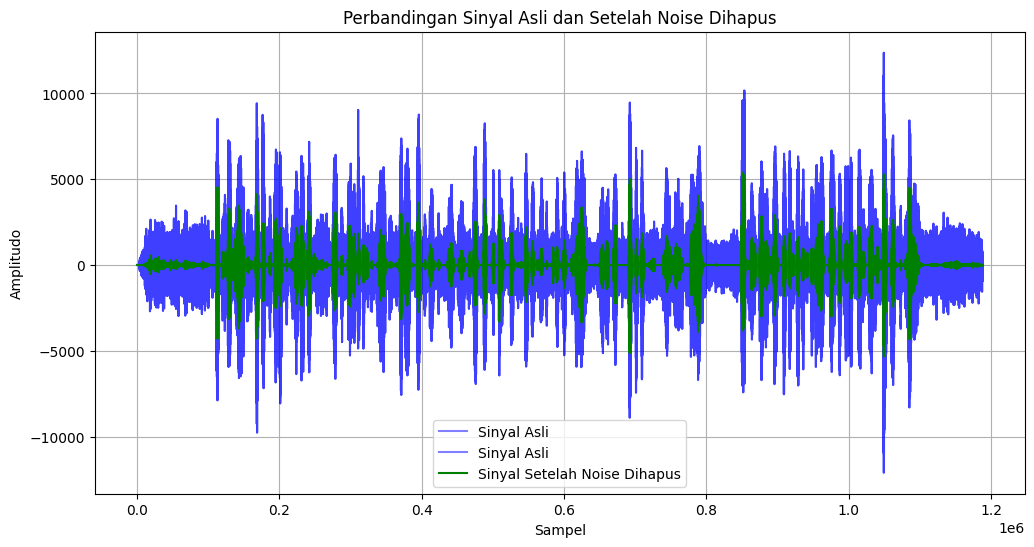

In [23]:
rate, processed_signal = wavfile.read(output_wav)

def overlay_signals(original_signal, processed_signal):
    plt.figure(figsize=(12, 6))

    plt.plot(original_signal, alpha=0.5, color='blue', label="Sinyal Asli")

    plt.plot(processed_signal, color='green', label="Sinyal Setelah Noise Dihapus")

    plt.title("Perbandingan Sinyal Asli dan Setelah Noise Dihapus")
    plt.xlabel("Sampel")
    plt.ylabel("Amplitudo")
    plt.legend()
    plt.grid()
    plt.show()

overlay_signals(original_signal, processed_signal)

# KONVERSI KE ADC

Langkah ketiga adalah mengonversi sinyal analog ke sinyal digital menggunakan simulasi konversi Analog-to-Digital Converter (ADC). Fungsi adc_conversion menerapkan proses kuantisasi dengan membagi sinyal menjadi level kuantisasi sesuai resolusi bit yang ditentukan (misalnya 3-bit), menghasilkan sinyal digital yang dikuantisasi. Setelah itu, fungsi plot_signal digunakan untuk memvisualisasikan perbandingan antara sinyal analog dan sinyal digital sebelum proses downsampling. Dalam visualisasi, sinyal analog direpresentasikan dengan garis halus, sedangkan sinyal digital digambarkan sebagai tangga untuk menunjukkan nilai-nilai kuantisasi pada waktu tertentu. Proses ini penting untuk mempersiapkan data audio dalam bentuk digital sebelum langkah-langkah analisis berikutnya.

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


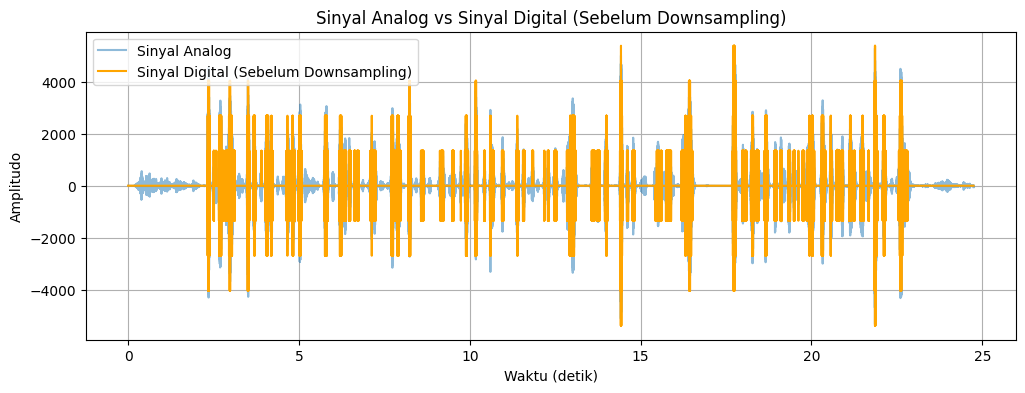

In [7]:
# Simulasi ADC
def adc_conversion(signal, bits=3):
    """
    Mengonversi sinyal analog ke sinyal digital menggunakan kuantisasi.
    - signal: Array sinyal input.
    - bits: Resolusi bit (jumlah bit untuk kuantisasi).
    """
    max_val = np.max(np.abs(signal))  # Amplitudo maksimum sinyal
    quantization_levels = 2 ** bits  # Jumlah level kuantisasi
    step_size = 2 * max_val / quantization_levels  # Jarak antar level
    quantized_signal = np.round(signal / step_size) * step_size  # Kuantisasi
    return quantized_signal

def plot_signal(analog_signal, digital_signal, sample_rate):
    """
    Plot sinyal analog dan sinyal digital sebelum downsampling.
    - analog_signal: Sinyal analog asli.
    - digital_signal: Sinyal digital hasil kuantisasi.
    - sample_rate: Sampling rate dari sinyal (dalam Hz).
    """
    # Waktu untuk sinyal analog dan digital
    time = np.linspace(0, len(analog_signal) / sample_rate, len(analog_signal))

    # Plot
    plt.figure(figsize=(12, 4))
    plt.plot(time, analog_signal, label="Sinyal Analog", alpha=0.5)
    plt.step(time, digital_signal, label="Sinyal Digital (Sebelum Downsampling)", where='post', color='orange')
    plt.title("Sinyal Analog vs Sinyal Digital (Sebelum Downsampling)")
    plt.xlabel("Waktu (detik)")
    plt.ylabel("Amplitudo")
    plt.legend()
    plt.grid()
    plt.show()

bits = 3  # Resolusi bit
digital_signal = adc_conversion(processed_signal, bits)

# Plot sinyal sebelum downsampling
plot_signal(processed_signal, digital_signal, sample_rate)


# ADC DENGAN DOWNSAMPLING

Langkah ini menambahkan proses downsampling setelah konversi ADC, yaitu mengurangi jumlah sampel dalam sinyal digital untuk mengurangi ukuran data atau meningkatkan efisiensi pemrosesan. Fungsi downsample mengambil setiap sampel ke-n dari sinyal digital berdasarkan faktor downsampling yang ditentukan (misalnya, 10). Fungsi plot_signal_after_downsampling kemudian memvisualisasikan perbandingan antara sinyal analog asli dan sinyal digital yang telah di-downsample. Waktu pada sinyal digital disesuaikan dengan faktor downsampling untuk menjaga keselarasan temporal. Langkah ini penting dalam pengolahan sinyal digital untuk mengoptimalkan data tanpa kehilangan informasi yang signifikan, terutama dalam aplikasi berbasis audio.

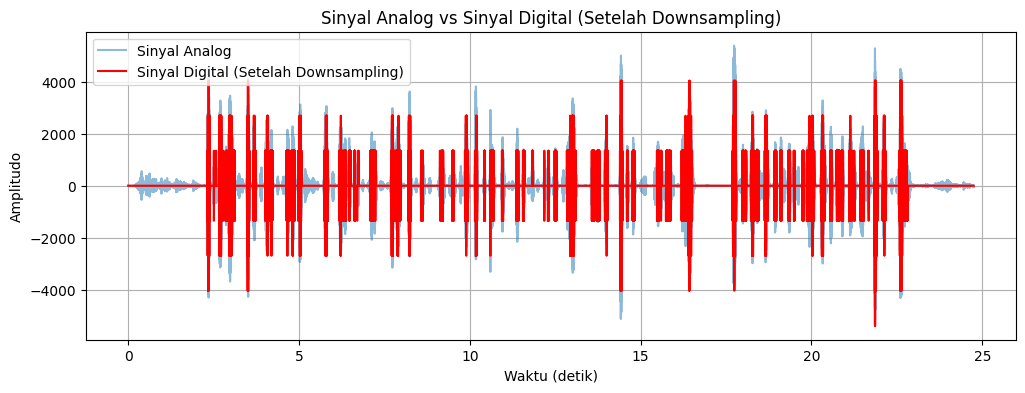

In [8]:
# Fungsi untuk downsampling sinyal
def downsample(signal, factor):
    """
    Melakukan downsampling pada sinyal.
    - signal: Array sinyal input.
    - factor: Faktor downsampling (ambil setiap n sampel).
    """
    return signal[::factor]

# Plot sinyal digital setelah downsampling
def plot_signal_after_downsampling(analog_signal, digital_signal, sample_rate, downsample_factor):
    """
    Plot sinyal analog dan sinyal digital setelah downsampling.
    - analog_signal: Sinyal analog asli.
    - digital_signal: Sinyal digital hasil kuantisasi.
    - sample_rate: Sampling rate dari sinyal (dalam Hz).
    - downsample_factor: Faktor downsampling untuk sinyal digital.
    """
    # Waktu untuk sinyal analog
    time_analog = np.linspace(0, len(analog_signal) / sample_rate, len(analog_signal))
    # Waktu untuk sinyal digital (setelah downsampling)
    time_digital = time_analog[::downsample_factor]
    # Downsample sinyal digital
    downsampled_signal = downsample(digital_signal, downsample_factor)

    # Plot
    plt.figure(figsize=(12, 4))
    plt.plot(time_analog, analog_signal, label="Sinyal Analog", alpha=0.5)
    plt.step(time_digital, downsampled_signal, label="Sinyal Digital (Setelah Downsampling)", where='post', color='red')
    plt.title("Sinyal Analog vs Sinyal Digital (Setelah Downsampling)")
    plt.xlabel("Waktu (detik)")
    plt.ylabel("Amplitudo")
    plt.legend()
    plt.grid()
    plt.show()

# Plot sinyal setelah downsampling
downsample_factor = 10
plot_signal_after_downsampling(processed_signal, digital_signal, sample_rate, downsample_factor)


# EKSTRAKSI FITUR MFCC

Langkah keempat adalah mengekstraksi fitur MFCC (Mel-Frequency Cepstral Coefficients), yang merupakan representasi numerik dari fitur-fitur akustik pada audio. Dengan pustaka librosa, file audio (dalam format WAV) dimuat menggunakan fungsi librosa.load, lalu fungsi librosa.feature.mfcc digunakan untuk menghitung koefisien MFCC berdasarkan skala mel. Hasil MFCC divisualisasikan menggunakan librosa.display.specshow, menampilkan representasi waktu terhadap koefisien MFCC dengan gradien warna yang menggambarkan intensitas. Fitur MFCC ini sering digunakan dalam pengenalan suara karena merepresentasikan karakteristik penting dari audio, seperti pola frekuensi yang relevan untuk analisis lebih lanjut.

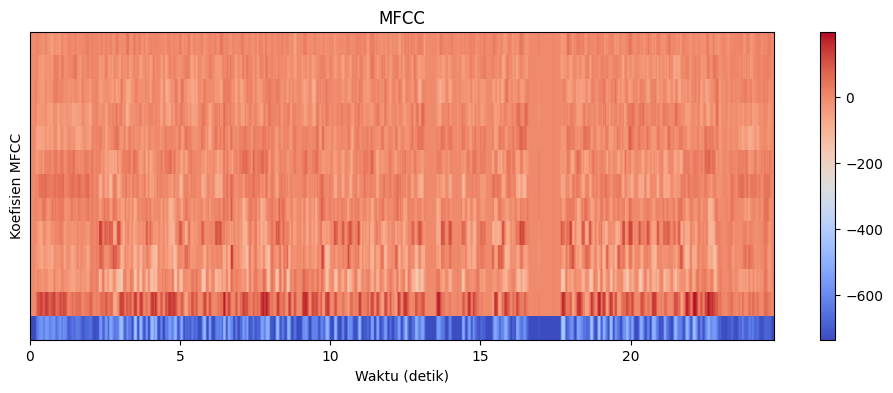

In [9]:
import librosa
import librosa.display

# Ekstraksi Fitur MFCC
def extract_mfcc(audio_path, n_mfcc=13):
    """
    Ekstraksi fitur MFCC dari file audio.
    - audio_path: Path ke file audio (WAV).
    - n_mfcc: Jumlah koefisien MFCC yang akan diekstrak.
    """
    y, sr = librosa.load(audio_path, sr=None)

    # Ekstraksi MFCC
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)

    # Plot MFCC
    plt.figure(figsize=(12, 4))
    librosa.display.specshow(mfccs, x_axis='time', sr=sr)
    plt.colorbar()
    plt.title('MFCC')
    plt.xlabel('Waktu (detik)')
    plt.ylabel('Koefisien MFCC')
    plt.show()

    return mfccs, sr

mfccs, sr = extract_mfcc(output_wav )

# EKSTRAKSI FITUR DTFT

Langkah ini mengekstraksi fitur spektral dari sinyal menggunakan DTFT (Discrete-Time Fourier Transform), yang dilakukan melalui algoritma FFT (Fast Fourier Transform). Fungsi plot_dtft menghitung transformasi Fourier untuk mengubah sinyal dari domain waktu ke domain frekuensi, menghasilkan spektrum frekuensi yang menunjukkan magnitudo pada berbagai komponen frekuensi. Hanya bagian positif dari frekuensi yang ditampilkan karena spektrum frekuensi bersifat simetris untuk sinyal real. Hasilnya divisualisasikan dalam grafik dengan sumbu frekuensi dan magnitudo, memberikan wawasan tentang konten frekuensi sinyal yang penting dalam analisis sinyal audio, seperti pengenalan pola atau penghapusan kebisingan berbasis frekuensi.

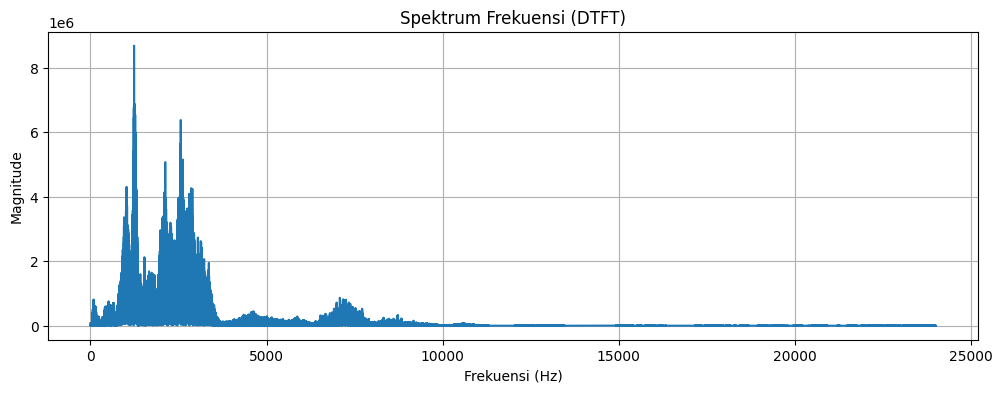

In [10]:
from scipy.fft import fft, fftfreq

# DTFT (Discrete-Time Fourier Transform)
def plot_dtft(signal, sample_rate):
    """
    Melakukan analisis spektral menggunakan DTFT.
    - signal: Sinyal input.
    - sample_rate: Sampling rate dari sinyal (dalam Hz).
    """
    # Hitung DTFT dari sinyal
    N = len(signal)
    T = 1 / sample_rate
    freqs = fftfreq(N, T)  # Frekuensi
    dtft_result = fft(signal)  # DTFT menggunakan FFT

    # Magnitude dan fase
    magnitude = np.abs(dtft_result)

    # Plot Spektrum Frekuensi
    plt.figure(figsize=(12, 4))
    plt.plot(freqs[:N // 2], magnitude[:N // 2])  # Hanya bagian positif dari frekuensi
    plt.title("Spektrum Frekuensi (DTFT)")
    plt.xlabel("Frekuensi (Hz)")
    plt.ylabel("Magnitude")
    plt.grid()
    plt.show()

    return freqs, magnitude

freqs, magnitude = plot_dtft(processed_signal, sample_rate)

# DETEKSI BAHASA, TRANSKRIP, DAN TRANSLATE

Langkah terakhir dalam proyek ini melibatkan deteksi bahasa, transkripsi, dan penerjemahan teks dari file audio. File audio diproses menggunakan model Whisper untuk mentranskripsi ucapan menjadi teks. Teks yang dihasilkan kemudian dianalisis dengan pustaka langdetect untuk menentukan bahasa sumbernya (Inggris atau Indonesia). Jika bahasa yang dideteksi adalah Inggris, teks diterjemahkan ke Indonesia, dan sebaliknya, menggunakan Google Translate API melalui pustaka googletrans. Proses ini berjalan secara otomatis baik untuk file tunggal maupun untuk kumpulan file dalam sebuah direktori.

Hasil akhirnya adalah teks asli, bahasa yang terdeteksi, dan terjemahannya yang dicetak ke konsol untuk setiap file audio yang diproses. Jika bahasa yang dideteksi tidak didukung, pesan peringatan akan ditampilkan. Pendekatan ini memungkinkan pengolahan dan penerjemahan file audio secara efisien, baik untuk penggunaan individu maupun batch, menjadikannya solusi yang fleksibel untuk aplikasi transkripsi dan penerjemahan lintas bahasa.

In [18]:
import os
import whisper
from langdetect import detect
from googletrans import Translator

def detect_language_from_audio(file_path):
    try:
        model = whisper.load_model("base")
        result = model.transcribe(file_path)
        text = result["text"]
        language = detect(text)
        return text, language
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None, None

def translate_text(text, source_language):
    try:
        translator = Translator()
        target_language = "id" if source_language == "en" else "en"
        translation = translator.translate(text, src=source_language, dest=target_language)
        return translation.text
    except Exception as e:
        print(f"Error during translation: {e}")
        return None

def process_and_translate_audio_files(path):
    if os.path.isfile(path):
        print(f"Processing file: {path}")
        text, language = detect_language_from_audio(path)
        if text:
            print(f"Extracted Text: {text}")
            print(f"Detected Language: {'Indonesian' if language == 'id' else 'English' if language == 'en' else 'Other'}")
            if language in ["id", "en"]:
                translated_text = translate_text(text, source_language=language)
                if translated_text:
                    print(f"Translated Text: {translated_text}")
            else:
                print("Language not supported for translation.")
        else:
            print(f"Failed to process {path}")
    elif os.path.isdir(path):
        for file_name in os.listdir(path):
            if file_name.endswith(".mp3"):
                file_path = os.path.join(path, file_name)
                print(f"Processing file: {file_name}")
                text, language = detect_language_from_audio(file_path)
                if text:
                    print(f"Extracted Text: {text}")
                    print(f"Detected Language: {'Indonesian' if language == 'id' else 'English' if language == 'en' else 'Other'}")
                    if language in ["id", "en"]:
                        translated_text = translate_text(text, source_language=language)
                        if translated_text:
                            print(f"Translated Text: {translated_text}")
                    else:
                        print("Language not supported for translation.")
                else:
                    print(f"Failed to process {file_name}")
    else:
        print(f"Path {path} is not valid. Please provide a valid file or folder path.")

process_and_translate_audio_files(output_mp3 )

Processing file: output_clean.mp3


/usr/local/lib/python3.10/dist-packages/whisper/__init__.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(fp, map_location=device)
/usr/local/li

Extracted Text:  Indonesia merupakan negara kepulawan yang seluruhnya terdiri atas kepulawan kepulawan dan mencakuk pula-pula besar dan kecil yang merupakan satu kesatuan wilayar, politik, ekonomi, sosial budaya. Dan histori yang batas-batas wilayanya di tarik dari garis pangkalki pulawan.
Detected Language: Indonesian
Translated Text: Indonesia is a state of the country which consists of entirely of the expansion and also covers the big and small tracts which are a unit of wilay, politics, economy, socio-cultural.And history whose boundaries are pulled from the Pangkalki Pulawan line.


# KESIMPULAN

Proyek ini bertujuan memberikan solusi praktis dalam penerjemahan suara berbasis teks antara bahasa Inggris dan Indonesia, dengan memanfaatkan metode pengolahan sinyal digital sederhana, dataset suara, dan layanan penerjemahan pihak ketiga. Sistem ini berhasil mengidentifikasi bahasa dalam dataset secara akurat dan menunjukkan performa yang baik dalam transkripsi serta penerjemahan. Meskipun terdapat kekurangan kecil, seperti ejaan yang kurang tepat dan frasa kompleks yang perlu penyempurnaan, proyek ini tetap memiliki potensi besar untuk menjadi alat efisien dalam mendukung komunikasi lintas bahasa dan kolaborasi global.